In [1]:
import numpy as np
import matplotlib.colorbar as colorbar
import matplotlib.pylab as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import astropy.units as u
import astropy.constants as const
import pandas as pd
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
from astropy.table import Table
from datetime import datetime
from scipy import stats
from PyAstronomy import pyasl

import sys
sys.path
sys.path.append(r"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\two_body\orbit_utilities")
print(sys.path)
import two_body_utils as utils

['C:\\Users\\macke\\OneDrive - Saint Marys University\\Summer Research 2025\\two_body', 'C:\\Users\\macke\\anaconda3\\python312.zip', 'C:\\Users\\macke\\anaconda3\\DLLs', 'C:\\Users\\macke\\anaconda3\\Lib', 'C:\\Users\\macke\\anaconda3', '', 'C:\\Users\\macke\\anaconda3\\Lib\\site-packages', 'C:\\Users\\macke\\anaconda3\\Lib\\site-packages\\win32', 'C:\\Users\\macke\\anaconda3\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\macke\\anaconda3\\Lib\\site-packages\\Pythonwin', 'C:\\Users\\macke\\anaconda3\\Lib\\site-packages\\setuptools\\_vendor', 'C:\\Users\\macke\\OneDrive - Saint Marys University\\Summer Research 2025\\two_body\\orbit_utilities']


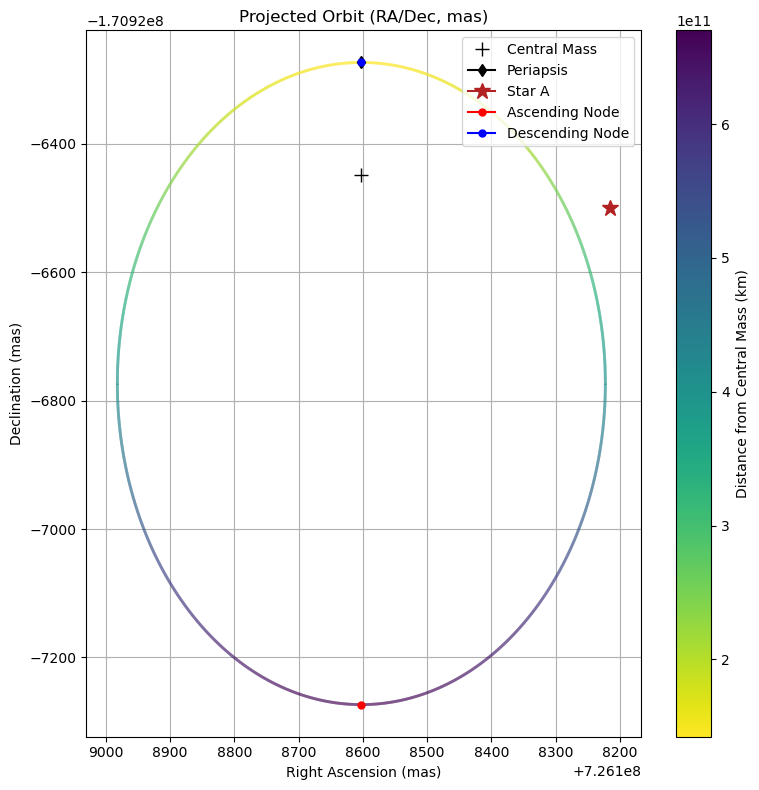

In [24]:
"""
Orbit Calculations and Plot with Absolute RA and DEC
"""

# ========================================================
# 1. Data and Unit Conversions
# ========================================================
# Star A 
ra_A   = (201.6967263 * u.deg).to(u.mas).value       # mas
dec_A  = (-47.4795835 * u.deg).to(u.mas).value       # mas
r_proj_A = (0.265 * u.arcsec).to(u.mas)              # projected separation


# Omega Centauri Center in deg
# We find the center to be at (α,δ) = (13:26:47.24, −47:28:46.45).
# from https://iopscience.iop.org/article/10.1088/0004-637X/710/2/1032
# reference 6 in Haberle et al. (2024; Nature, Vol. 631) 
# We assume the IMBH is located at the cluster center
ra_cm_deg = 201.696834*u.deg
dec_cm_deg = -47.479569*u.deg
# Omega Centauri centre in mas
ra_cm_mas  = ra_cm_deg.to(u.mas).value
dec_cm_mas = dec_cm_deg.to(u.mas).value

# Cluster distance
dist_pc = 5.43 * 1000 * u.pc
dist_km = dist_pc.to(u.km).value                     # km
km_to_mas = (1 / dist_km) * 206_265_000              # km to mas  (206 265 arcsec × 1 000)

# ========================================================
# 1. Orbital Parameters
# ========================================================
e = 0.65                                      # Eccentricity
a = utils.orbit_semi_major.value              # Semi-major axis (km)
per = utils.circular_period(semi_major=utils.orbit_semi_major, speed=utils.v_xyz_sample).value    # Period (s)
tau = utils.tau                               # Time of periapsis passage
Omega = utils.Omega                           # Longitude of ascending node (deg)
w = utils.w                                   # Argument of periapsis (deg)
i = utils.i                                   # Inclination (deg)

# Time array over one orbit period
t = np.linspace(tau, tau + per, utils.n_int)

# ========================================================
# 2. Orbit and Positions
# ========================================================
ke = pyasl.KeplerEllipse(a=a, per=per, e=e, Omega=Omega, i=i, w=w)  # Kepler orbit instance
pos = ke.xyzPos(t)                                                 # Position (km) over time array
ascn, descn = ke.xyzNodes_LOSZ()                                  # Ascending/descending nodes (km)

# ========================================================
# 3. Positions to sky coordinates (mas)
# ========================================================
# Linear to angular offsets (mas)
ra_off  = -pos[:, 1] * km_to_mas       # east negative     
dec_off =  pos[:, 0] * km_to_mas       # north positive

# Absolute coordinates (mas)
ra_abs  = ra_cm_mas  + ra_off
dec_abs = dec_cm_mas + dec_off

# Nodes and periapsis
ascn_ra  = ra_cm_mas  + (-ascn[1] * km_to_mas)
ascn_dec = dec_cm_mas + ( ascn[0] * km_to_mas)

descn_ra  = ra_cm_mas  + (-descn[1] * km_to_mas)
descn_dec = dec_cm_mas + ( descn[0] * km_to_mas)

peri_ra  = ra_cm_mas  + (-pos[0, 1] * km_to_mas)
peri_dec = dec_cm_mas + ( pos[0, 0] * km_to_mas)

# ========================================================
# 4. Plot Projected Orbit
# ========================================================

fig, ax = plt.subplots(figsize=(8, 8))

# Create line segments from orbit points
points = np.array([ra_abs, dec_abs]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Compute distance from center in km for each point (projected)
dists = np.sqrt(pos[:, 0]**2 + pos[:, 1]**2)

# Proper normalization (min < max) and reversed colormap so closest=brightest
norm = Normalize(vmin=dists.min(), vmax=dists.max())
lc = LineCollection(segments, cmap='viridis_r', norm=norm)
lc.set_array(dists)
lc.set_linewidth(2)

# Add the colored orbital path
line = ax.add_collection(lc)

# === Other markers ===
ax.plot(ra_cm_mas, dec_cm_mas, 'k+', markersize=10, label='Central Mass')
ax.plot(peri_ra,  peri_dec, marker = 'd', color = 'black', label='Periapsis')
ax.plot(ra_A, dec_A, marker='*', color='firebrick', markersize=12, label='Star A')
# ax.plot(ascn_ra,  ascn_dec,  marker = 'o', color = 'red', markersize=5, label='Ascending Node')
# ax.plot(descn_ra, descn_dec, marker = 'o', color = 'blue', markersize=5, label='Descending Node')


# === Colorbar ===
cbar = plt.colorbar(line, ax=ax)
cbar.set_label("Distance from Central Mass (km)")

# === Plot formatting ===
ax.set_title("Projected Orbit (RA/Dec, mas)")
ax.set_xlabel("Right Ascension (mas)")
ax.set_ylabel("Declination (mas)")
ax.invert_xaxis()      # RA increases leftward
ax.axis('equal')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


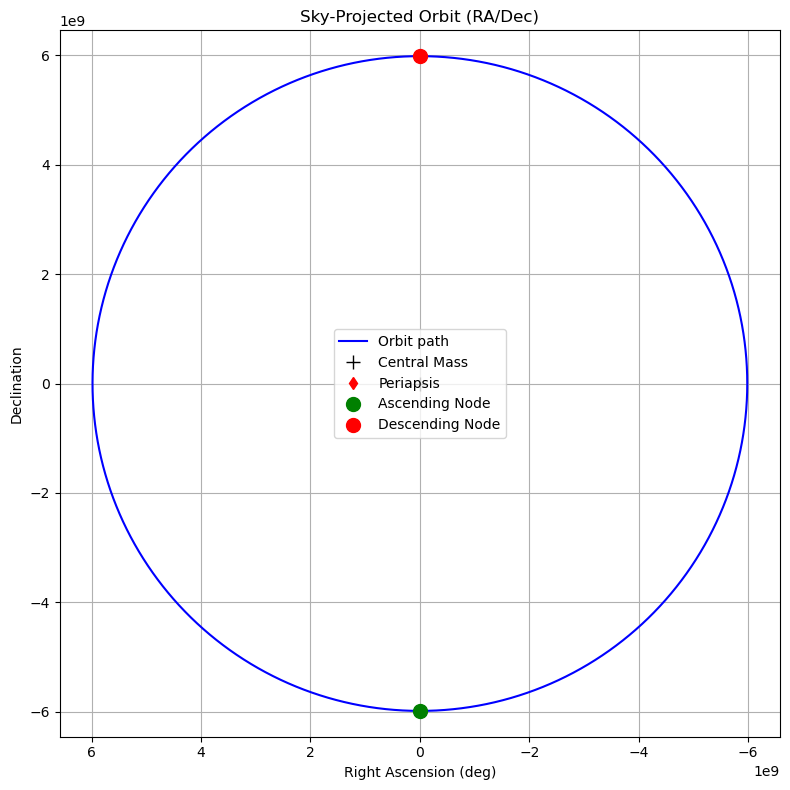

In [3]:
"""
Orbit Calculations and Plots with Relative KeplerElipse RA and DEC
"""

# ========================================================
# 1. Set Orbital Parameters
# ========================================================
e = 0                        # Eccentricity
a = utils.semi_major_sample.value       # Semi-major axis
per = utils.circular_period(semi_major=utils.semi_major_sample, speed=utils.v_xyz_sample).value    # Period
tau = utils.tau               # Time of periapsis
Omega = utils.Omega           # Longitude of ascending node (deg)
w = utils.w                   # Argument of periapsis (deg)
i = utils.i                   # Inclination (deg)

# Time array over one period (in seconds)
t = np.linspace(tau, tau + per, utils.n_int)

# ========================================================
# 2. Instantiate Orbit and Compute Positions
# ========================================================
ke = pyasl.KeplerEllipse(a=a, per=per, e=e, Omega=Omega, i=i, w=w)

# Position as a function of time (in 3D)
pos = ke.xyzPos(t)

# Nodes for observer at -z
ascn, descn = ke.xyzNodes_LOSZ()

# ========================================================
# 3. Plot Orbit (RA vs Dec)
# ========================================================
fig, ax = plt.subplots(figsize=(8, 8))

# Plot orbital trajectory in RA-Dec plane
# Convention: RA increases to the left (east), Dec increases up (north)
ax.plot(-pos[:, 1], pos[:, 0], 'b-', label='Orbit path')  # -RA vs Dec

# Central mass
ax.plot(0, 0, 'k+', markersize=10, label='Central Mass')

# Periapsis
ax.plot(-pos[0, 1], pos[0, 0], 'rd', label='Periapsis')

# Nodes
ax.plot(-ascn[1], ascn[0], 'go', markersize=10, label='Ascending Node')
ax.plot(-descn[1], descn[0], 'ro', markersize=10, label='Descending Node')

# ========================================================
# 4. Format Sky Plot
# ========================================================
ax.set_title("Sky-Projected Orbit (RA/Dec)")
ax.set_xlabel("Right Ascension (deg)")        # East to the left
ax.set_ylabel("Declination")            # North up
ax.invert_xaxis()                       # Standard astronomical RA direction
ax.axis('equal')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


In [4]:
# """
# Binary Orbit Plots and Calculations
# """

# import numpy as np
# import matplotlib.pyplot as plt
# from PyAstronomy import pyasl

# # ========================================================
# # 1. Define Orbital Parameters
# # ========================================================
# e = 0                                     # Eccentricity
# a = utils.semi_major_sample.value         # Semi-major axis [m]
# per = utils.circular_period(
#     semi_major=utils.semi_major_sample, 
#     speed=utils.v_xyz_sample
# ).value                                   # Orbital period [s]
# tau = utils.tau                           # Time of periapsis [d]
# Omega = utils.Omega                       # Longitude of ascending node [deg]
# w = utils.w                               # Argument of periapsis [deg]
# i = utils.i                               # Inclination [deg]

# # Time array spanning one orbit (converted to seconds for computation)
# t = np.linspace(tau, tau + per / 86400, utils.n_int) * 86400

# # ========================================================
# # 2. Create Binary Orbit and Get Orbital Elements
# # ========================================================
# bo = pyasl.BinaryOrbit(
#     m2m1=utils.m2m1,                      # Mass ratio m2/m1
#     mtot=utils.mtot,                      # Total mass [M_sun]
#     per=per / 86400,                      # Period [days]
#     e=e,                                  # Eccentricity
#     tau=tau,                              # Time of periapsis [days]
#     Omega=Omega,                          # Longitude of ascending node [deg]
#     w=w,                                  # Argument of periapsis [deg]
#     i=i                                   # Inclination [deg]
# )

# # Get Keplerian ellipses for both stars
# ke1 = bo.getKeplerEllipse_primary()
# ke2 = bo.getKeplerEllipse_secondary()

# # ========================================================
# # 3. Compute Positions and Velocities Over Time
# # ========================================================
# r1, r2 = bo.xyzPos(t)                     # Positions [m]
# v1, v2 = bo.xyzVel(t)                     # Velocities [m/s]

# # ========================================================
# # 4. Plot Binary Star Orbits
# # ========================================================
# plt.figure(figsize=(8, 6))
# plt.plot(r1[:, 0], r1[:, 1], 'b.-', label="Primary orbit")
# plt.plot(r2[:, 0], r2[:, 1], 'r.-', label="Secondary orbit")
# plt.xlabel("x [m]")
# plt.ylabel("y [m]")
# plt.title("Binary Orbit Trajectories")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # ========================================================
# # 5. Plot Relative Distance Between Stars Over Time
# # ========================================================
# rd = np.linalg.norm(r1 - r2, axis=1)  # Relative distance

# plt.figure(figsize=(8, 4))
# plt.plot(t / 86400, rd, 'b.-', label="Relative distance")
# plt.axvline(tau, ls=':', c='k', label="Time of periastron")
# plt.xlabel("Time [days]")
# plt.ylabel("Separation [m]")
# plt.title("Relative Distance Between Binary Components")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # ========================================================
# # 6. Plot Velocities of Both Stars
# # ========================================================
# fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# # x-velocity
# axs[0].plot(t / 86400, v1[:, 0] / 1e3, 'b.-', label="Primary")
# axs[0].plot(t / 86400, v2[:, 0] / 1e3, 'r.-', label="Secondary")
# axs[0].set_ylabel("vx [km/s]")
# axs[0].set_title("x-component of Velocity")
# axs[0].legend()
# axs[0].grid(True)

# # y-velocity
# axs[1].plot(t / 86400, v1[:, 1] / 1e3, 'b.-', label="Primary")
# axs[1].plot(t / 86400, v2[:, 1] / 1e3, 'r.-', label="Secondary")
# axs[1].set_ylabel("vy [km/s]")
# axs[1].set_title("y-component of Velocity")
# axs[1].legend()
# axs[1].grid(True)

# # Orbital speed (magnitude of velocity vector)
# ov1 = np.linalg.norm(v1, axis=1)
# ov2 = np.linalg.norm(v2, axis=1)
# axs[2].plot(t / 86400, ov1 / 1e3, 'b.-', label="Primary")
# axs[2].plot(t / 86400, ov2 / 1e3, 'r.-', label="Secondary")
# axs[2].set_xlabel("Time [days]")
# axs[2].set_ylabel("Speed [km/s]")
# axs[2].set_title("Total Orbital Speed")
# axs[2].legend()
# axs[2].grid(True)

# plt.tight_layout()
# plt.show()


In [5]:
# 2d velocities:
# Measured v2D A: (113.0±1.1) km s−1 B: (66.6±4.1) km s−1 C: (94.9±1.7) km s−1 D: (77.9±2.0) km s−1 E: (69.6±0.8) km s−1 F: (67.4±0.4) km s−1 G: (66.2±1.9) km s−1
v2D = np.array([113.0, 66.6, 94.9, 77.9, 69.6, 67.4, 66.2]) * u.km / u.s
v2D_err = np.array([1.1, 4.1, 1.7, 2.0, 0.8, 0.4, 1.9]) * u.km / u.s

In [6]:
# Acceleration R.A. [mas/yr^2] -0.0069±0.0083 (0.8σ) 0.0702±0.0239 (2.9σ) 0.0028±0.0333 (0.1σ) 0.0357±0.0177 (2.0σ) 0.0072±0.0042 (1.7σ) 0.0052±0.0038 (1.4σ)  -0.0197±0.0267 (0.7σ)
a_ra = (np.array([-0.0069, 0.0702, 0.0028, 0.0357, 0.0072, 0.0052, -0.0197]))* u.mas/ u.yr**2
a_ra_err = (np.array([0.0083, 0.0239, 0.0333, 0.0177, 0.0042, 0.0038, 0.0267])) * u.mas / u.yr**2

# Acceleration Dec. [mas/yr^2] 0.0085±0.0098 (0.9σ) 0.0228±0.0157 (1.5σ) -0.0060±0.0123 (0.5σ) -0.0194±0.0162 (1.2σ) -0.0009±0.0075 (0.1σ) -0.0015±0.0038 (0.4σ) 0.0173±0.0170 (1.0σ)
a_dec = (np.array([0.0085, 0.0228, -0.0060, -0.0194, -0.0009, -0.0015, 0.0173]))* u.mas/ u.yr**2
a_dec_err = (np.array([0.0098, 0.0157, 0.0123, 0.0162, 0.0075, 0.0038, 0.0170])) * u.mas / u.yr**2

# Acceleration in the plane of the sky [mas/yr^2]
a_prop = (np.array([0.0109, 0.0759, 0.0066, 0.0406, 0.0073, 0.0054, 0.0262]))*u.mas/ u.yr**2
a_prop_err = (np.array([0.0092, 0.0229, 0.0180, 0.0174, 0.0043, 0.0038, 0.0230]))*u.mas/ u.yr**2
